In [ ]:
import sys
sys.path.append('../../')
sys.path.append('../')
import time
import wd
from graphviz import Digraph
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.fx as fx


In [19]:
name_list =[
  'embedding_embedding',
  'view',
  'mlp_mlp_0'
]

In [25]:
def draw(graph):
    dot = Digraph(comment='graph', graph_attr={'rankdir': 'LR'},format='png')
    root = graph._root
    cur = root._next
    while cur is not root:
        if not cur._erased and cur.op != "get_attr":
            dot.node(cur.name,cur.name,style='filled',
                    shape='box',
                    align='left',
                    fontsize='10',
                    ranksep='0.1',
                    height='0.2',
                    fontname='monospace',fillcolor='White' if cur.name not in name_list else 'Orange')
            for arg in cur.args:
                if isinstance(arg,torch.fx.node.Node) and arg.op != "get_attr":
                    dot.edge(arg.name,cur.name)
                if isinstance(arg,list):
                    for item in arg:
                        dot.edge(item.name,cur.name)
        cur = cur._next
    return dot

In [6]:
wdl_model_ori = wd.WideAndDeepModel([100 for i in range(110)],32,[400,400,400],0.1)

In [7]:
wdl_model = fx.symbolic_trace(wdl_model_ori)
ga = wdl_model.graph

In [12]:
ga._root.next.op

'placeholder'

In [26]:
dot = draw(ga)

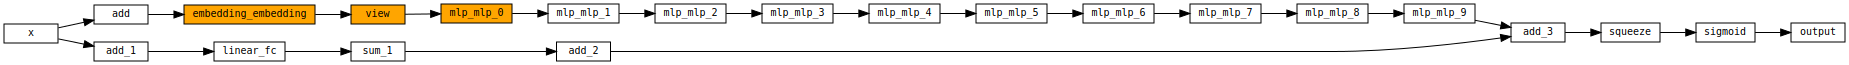

In [28]:
dot

In [30]:
dot.render('round-table.gv',format='jpg')  


'round-table.gv.jpg'

In [31]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.fx import subgraph_rewriter, symbolic_trace
import utils
from torch.fx import Proxy, Graph, GraphModule
from torch.fx.passes.utils.matcher_utils import SubgraphMatcher
from torch.profiler import profile, record_function, ProfilerActivity
import time
import torch._dynamo as dynamo

replace success!


In [37]:
def gen_pattern_replace_and_matcher_for_MLP(traced,
                                                  redency_part_slice,unredency_part_slice,
                                                  key_node_name,match_func = None
                                                ):
  from torch.fx.passes.utils.matcher_utils import SubgraphMatcher


  def _match(match,ori,pat):
    return True 
  env  = utils.get_env(traced)
  target_node = env[key_node_name]
  target_node_mod = utils.get_target_mod(traced,target_node.target)
  shape_info = target_node_mod.weight.data.shape
  class PatternClass(torch.nn.Module):
      def __init__(self):
          super().__init__()
          self.embed = torch.nn.Embedding(1, 1)
          self.embed_output_dim = shape_info[1]
          self.mlp = nn.Linear(shape_info[0],shape_info[1])


      def forward(self,x):
          x = self.embed(x).view(-1,self.embed_output_dim)
          return self.mlp(x)
  pattern = PatternClass()  
  pattern_trace = symbolic_trace(pattern)
  pattern_graph = pattern_trace.graph
  original_graph = traced.graph
  matcher =  SubgraphMatcher(pattern_graph, match_output=False, match_placeholder=False,
                              remove_overlapping_matches=True)
  _matches = matcher.match(original_graph)
  match_filters = [_match if match_func is None else match_func]
  _matches = [
      m for m in _matches
      if all(match_filter(m, original_graph, pattern_graph)
              for match_filter in match_filters)
  ]  
  # 因为在过滤器中做了限制应该只有一个符合要求的
  _matched = _matches[0]
  pattern_env = utils.get_env(pattern_trace)
  node_map = _matched.nodes_map
  
  embed_node = node_map[pattern_env['embed']]
  embed_node_module = utils.get_target_mod(traced,embed_node.target)
  
  linear_node = node_map[pattern_env['mlp']]
  linear_node_module = utils.get_target_mod(traced,linear_node.target)
  linear_node_weight = linear_node_module.weight.data
  linear_node_bias = linear_node_module.bias.data
  
  class ReplacementClass(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.embed = embed_node_module
      self.embed_dim = self.embed.weight.data.shape[1]
      self.redency_weight_len = self.embed_dim * redency_part_slice[1].stop
      redency_weight = linear_node_weight[:,:self.redency_weight_len]
      unredency_weight = linear_node_weight[:,self.redency_weight_len:]
      self.unredency_weight_len = unredency_weight.shape[1]
      self.redundancy_linear = nn.Linear(redency_weight.shape[1],redency_weight.shape[0])
      self.redundancy_linear.weight.data.copy_(redency_weight)
      self.redundancy_linear.bias.data.copy_(linear_node_bias)

      self.non_redundancy_linear = nn.Linear(unredency_weight.shape[1],unredency_weight.shape[0],bias=False)
      self.non_redundancy_linear.weight.data.copy_(unredency_weight)

      

    def forward(self,x):
      redency_part = x[redency_part_slice] 
      unredency_part = x[unredency_part_slice] 
      return self.redundancy_linear(self.embed(redency_part).view(-1,self.redency_weight_len)) + self.non_redundancy_linear(self.embed(unredency_part).view(-1,self.unredency_weight_len))
      # return unredency_sum
    
  
  return pattern,ReplacementClass(),_match

In [38]:
def workload_wdl(num_field, prefix,dim = 64,l = [1024,512,256]):
  print(f"now gen workload of wdl with config: dim: {dim}, num_field: {num_field}, prefix: {prefix}")
  wdl_model_ori = wd.WideAndDeepModel([100 for i in range(num_field)],dim,l,0.1)
  ori_traced = fx.symbolic_trace(wdl_model_ori)
  
  wdl_model_modify = wd.WideAndDeepModel([100 for i in range(num_field)],dim,l,0.1)
  modify_traced = fx.symbolic_trace(wdl_model_modify)
  pattern,replace,match = gen_pattern_replace_and_matcher_for_MLP(modify_traced,
                                                                      (0,slice(None,prefix,None)),(slice(None,None,None),slice(prefix,None,None)),
                                                                      "mlp_mlp_0")
  matches = subgraph_rewriter.replace_pattern_with_filters(modify_traced, pattern, replace,[match])
  return ori_traced,modify_traced

In [39]:
ori, modify = workload_wdl(110,50,32)

now gen workload of wdl with config: dim: 32, num_field: 110, prefix: 50


In [48]:
dot = draw(modify.graph)

In [45]:
name_list =[
  'getitem',
  'getitem_1',
  'embed',
  'embed_1',
  'view_1',
  'view_2',
  'redundancy_linear',
  'non_redundancy_linear',
  'add_4'
  
]

In [46]:
def draw(graph):
    dot = Digraph(comment='graph', graph_attr={'rankdir': 'LR'},format='png')
    root = graph._root
    cur = root._next
    while cur is not root:
        if not cur._erased and cur.op != "get_attr":
            dot.node(cur.name,cur.name,style='filled',
                    shape='box',
                    align='left',
                    fontsize='10',
                    ranksep='0.1',
                    height='0.2',
                    fontname='monospace',fillcolor='White' if cur.name not in name_list else 'Orange')
            for arg in cur.args:
                if isinstance(arg,torch.fx.node.Node) and arg.op != "get_attr":
                    dot.edge(arg.name,cur.name)
                if isinstance(arg,list):
                    for item in arg:
                        dot.edge(item.name,cur.name)
        cur = cur._next
    return dot

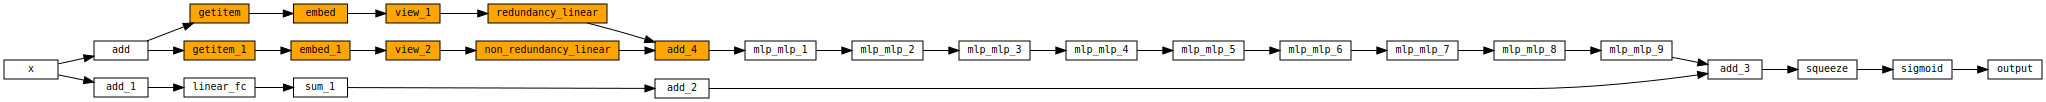

In [49]:
dot

In [50]:
dot.render('modify',format='jpg')  

'modify.jpg'